In [1]:
# --------------------------------------------------
# 0. 기본 설정
# --------------------------------------------------
import os, glob, random
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

device = cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
seg_img_dir = "/content/drive/MyDrive/Data/CV_dataset_2/Segmentation/images"
mask_img_dir = "/content/drive/MyDrive/Data/CV_dataset_2/Segmentation/masks_multichannel"
img_size = 256

In [4]:
# --------------------------------------------------
# 1. 데이터셋 정의
# --------------------------------------------------
def get_transforms(img_size=(256, 256)):
    transform_img = transforms.Compose([
        transforms.Resize(img_size, interpolation=Image.BILINEAR),
        transforms.ToTensor(),                                  # (3,H,W) float32 [0,1]
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    def transform_mask(mask_pil):
        # (H,W) uint8 → float32 [0,1], shape (1,H,W)
        mask = torch.from_numpy(np.array(mask_pil, dtype=np.float32) / 255.0)
        if mask.ndim == 2:          # 단일 채널이면 (H,W) → (1,H,W)
            mask = mask.unsqueeze(0)
        else:                       # RGB 마스크라면 채널별 3개
            mask = mask.permute(2, 0, 1)
        return mask
    return transform_img, transform_mask


class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=(256, 256)):
        self.img_dir, self.mask_dir = img_dir, mask_dir
        self.img_names  = sorted(os.listdir(img_dir))
        self.mask_names = sorted(os.listdir(mask_dir))
        assert len(self.img_names) == len(self.mask_names)

        self.t_img, self.t_mask = get_transforms(img_size)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img  = Image.open(os.path.join(self.img_dir,  self.img_names[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.mask_names[idx])) # ch 3 -> tensor / numpy

        return self.t_img(img), self.t_mask(mask)

In [5]:
from torch.utils.data import random_split
full_datasets = SegDataset(seg_img_dir, mask_img_dir, img_size=(256,256))

train_size = int(0.8 * len(full_datasets)) # Train Test split
val_size  = len(full_datasets) - train_size

train_datasets, val_datasets = random_split(full_datasets, [train_size, val_size])

train_loader = DataLoader(
    train_datasets,
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    val_datasets,
    batch_size=16
)

In [6]:
for d,l in train_loader:
    print(d.shape, l.shape)
    break

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


In [7]:
# Conv Block 생성
def conv_block(in_c, out_c):
    """Conv → BN → ReLU 두 번"""
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c), # Batch Norm
        nn.ReLU(),

        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c), # Batch Norm
        nn.ReLU()
    )

# AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder 3, 256, 256
        self.c1 = conv_block(3, 64)     #  H × W
        self.p1 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)      #  H/2 × W/2
        self.c2 = conv_block(64, 128)
        self.p2 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)      #  H/4 × W/4
        self.c3 = conv_block(128, 256)
        self.p3 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)     #  H/8 × W/8
        self.c4 = conv_block(256, 512)
        self.p4 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)      #  H/16 × W/16

        # Bottleneck
        self.c5 = conv_block(512, 1024) #  H/16 × W/16

        # Decoder
        # (Upsample → ConvBlock)의 반복
        self.u4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d4 = conv_block(512, 512)

        self.u3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)   #  H/4
        self.d3 = conv_block(256, 256)

        self.u2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)    #  H/2
        self.d2 = conv_block(128, 128)

        self.u1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   #  H
        self.d1 = conv_block(64, 64)   # 64, 256, 256

        # 출력 레이어 (시그모이드 직전)
        self.out = nn.Conv2d(64, 3, kernel_size=1) # 3, 256, 256

    def forward(self, x):
        # Encoder
        x = F.relu(self.p1(self.c1(x)))
        x = F.relu(self.p2(self.c2(x)))
        x = F.relu(self.p3(self.c3(x)))
        x = F.relu(self.p4(self.c4(x)))

        # Bottleneck
        x = self.c5(x)

        # Decoder
        x = self.d4(F.relu(self.u4(x)))
        x = self.d3(F.relu(self.u3(x)))
        x = self.d2(F.relu(self.u2(x)))
        x = self.d1(F.relu(self.u1(x)))

        # 출력 레이어
        return self.out(x)   # Logits 반환(BCEWithLogitsLoss와 호환)

model = AutoEncoder().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
crit = nn.BCEWithLogitsLoss()          # 픽셀 단위 이진 분류

In [8]:
# --------------------------------------------------
# 3. 학습 루프
# --------------------------------------------------
def iou_score(pred, mask, thresh=0.5, eps=1e-6):
    pred = (pred>thresh).float()
    inter = (pred*mask).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + mask.sum(dim=(1,2,3)) - inter
    return ((inter+eps)/(union+eps)).mean().item()

best_iou = 0
for epoch in range(1, 201):
    # ---- Train ----
    model.train()
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
        logits = model(imgs)
        loss = crit(logits, masks)
        opt.zero_grad(); loss.backward(); opt.step()

    # ---- Validate ----
    model.eval()
    val_loss, val_iou = 0,0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            logits = model(imgs)
            val_loss += crit(logits, masks).item()*imgs.size(0)
            val_iou += iou_score(torch.sigmoid(logits), masks)*imgs.size(0)
    val_loss /= len(val_datasets); val_iou /= len(val_datasets)
    print(f"[{epoch:02d}] val_loss={val_loss:.4f}  IoU={val_iou:.4f}")

    # ---- Checkpoint ----
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'best_seg_model.pth')
        print("Best model saved!")


[01] val_loss=0.6387  IoU=0.0478
Best model saved!
[02] val_loss=0.6279  IoU=0.0841
Best model saved!
[03] val_loss=0.5032  IoU=0.3281
Best model saved!
[04] val_loss=0.4538  IoU=0.3338
Best model saved!
[05] val_loss=0.4205  IoU=0.3929
Best model saved!
[06] val_loss=0.3991  IoU=0.3838
[07] val_loss=0.3983  IoU=0.3849
[08] val_loss=0.4103  IoU=0.3864
[09] val_loss=0.3643  IoU=0.5413
Best model saved!
[10] val_loss=0.3439  IoU=0.6476
Best model saved!
[11] val_loss=0.3278  IoU=0.7107
Best model saved!
[12] val_loss=0.3438  IoU=0.5140
[13] val_loss=0.2966  IoU=0.7363
Best model saved!
[14] val_loss=0.2837  IoU=0.7667
Best model saved!
[15] val_loss=0.2754  IoU=0.7838
Best model saved!
[16] val_loss=0.2597  IoU=0.8563
Best model saved!
[17] val_loss=0.2461  IoU=0.8630
Best model saved!
[18] val_loss=0.2420  IoU=0.8580
[19] val_loss=0.2318  IoU=0.8485
[20] val_loss=0.2244  IoU=0.8541
[21] val_loss=0.2151  IoU=0.8676
Best model saved!
[22] val_loss=0.2120  IoU=0.8660
[23] val_loss=0.2105  

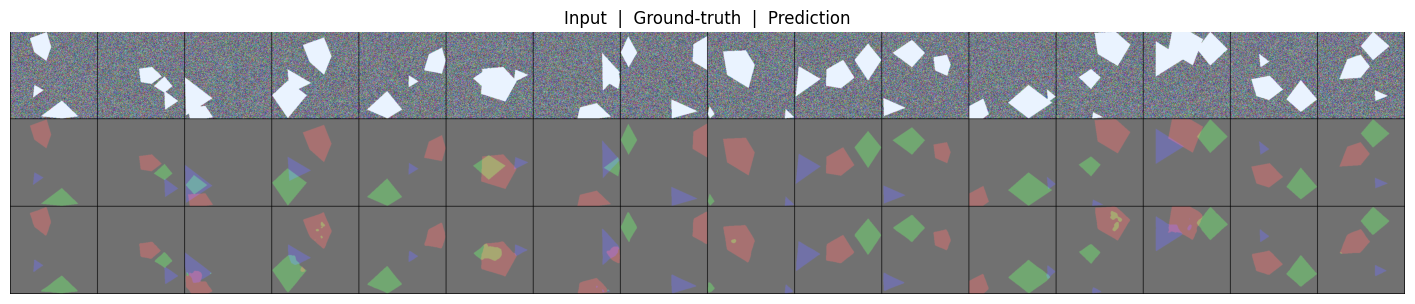

In [9]:
# --------------------------------------------------
# 4. 예측 시각화
# --------------------------------------------------
model.load_state_dict(torch.load('./best_seg_model.pth'))

def prepare_vis_tensor(x):
    """
    x : (N,C,H,W)
    반환 : (N,3,H,W)   # 시각화용 3채널
    """
    # 1) 시그모이드·빈 threshold → 0/1 로 이진화
    #    (예측 확률 텐서만 들어올 수도 있음)
    if x.dtype.is_floating_point and x.max() <= 1.0:
        x = (x > 0.5).float()

    # 2) C==1 → 1→3 repeat
    if x.size(1) == 1:
        x = x.repeat(1, 3, 1, 1)          # (N,3,H,W)
    # 3) C>3 → 가장 높은 채널 argmax → 1채널 → 3 repeat
    elif x.size(1) > 3:
        x = x.argmax(1, keepdim=True).float().repeat(1, 3, 1, 1)
    # 4) C==3 → 그대로 사용
    return x

# ── 시각화 루틴 ──────────────────────────────────
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))          # 한 배치
    imgs  = imgs.to(device, non_blocking=True)
    masks = masks.to(device, non_blocking=True)

    preds = torch.sigmoid(model(imgs))            # (N,1,H,W) or (N,C,H,W)

# 텐서를 모두 3채널로 맞춤
vis_imgs   = imgs.cpu()                           # 이미 3채널
vis_masks  = prepare_vis_tensor(masks.cpu())
vis_preds  = prepare_vis_tensor(preds.cpu())

# (3N, 3, H, W) 로 이어 붙인 뒤 그리드 생성
grid = make_grid(torch.cat([vis_imgs, vis_masks, vis_preds], dim=0),
                 nrow=imgs.size(0), padding=2, normalize=True)

plt.figure(figsize=(18, 6))
plt.axis('off')
plt.title("Input  |  Ground‑truth  |  Prediction")
plt.imshow(grid.permute(1, 2, 0))
plt.show()

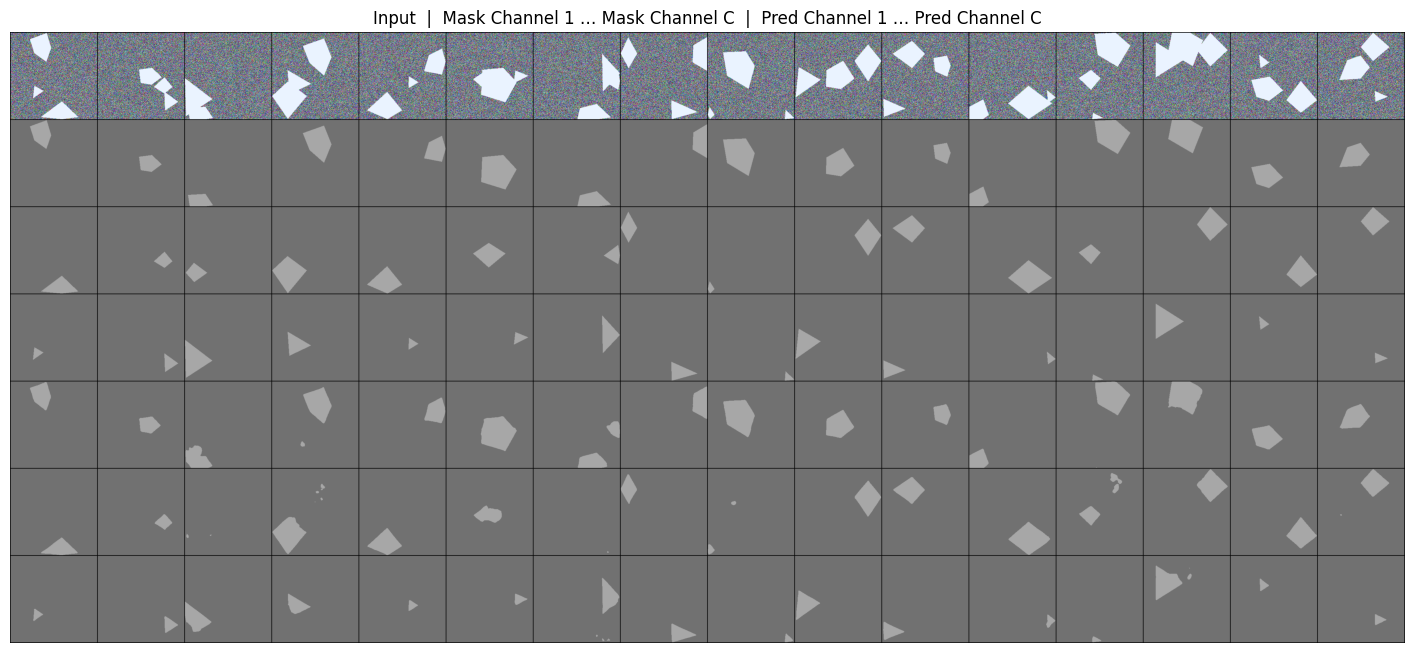

In [10]:
# model.load_state_dict(torch.load('./best_seg_model.pth'))
model.eval()

with torch.no_grad():
    imgs, masks = next(iter(val_loader))             # 한 배치
    imgs  = imgs.to(device, non_blocking=True)
    masks = masks.to(device, non_blocking=True)
    preds = torch.sigmoid(model(imgs))               # (N, C, H, W) or (N,1,H,W)

# 1) 입력 이미지는 그대로 (N,3,H,W)
vis_imgs = imgs.cpu()

# 2) 마스크와 예측을 채널별로 3채널로 복제
mask_channels = masks.size(1)
pred_channels = preds.size(1)

vis_list = [vis_imgs]

# (a) 정답 마스크 채널별
for c in range(mask_channels):
    single_mask = masks.cpu()[:, c:c+1, :, :]       # (N,1,H,W)
    mask_3ch    = single_mask.repeat(1, 3, 1, 1)    # (N,3,H,W)
    vis_list.append(mask_3ch)

# (b) 예측 결과 채널별 (threshold 후 이진화)
for c in range(pred_channels):
    single_pred = preds.cpu()[:, c:c+1, :, :]
    bin_pred    = (single_pred > 0.5).float()       # 이진화
    pred_3ch    = bin_pred.repeat(1, 3, 1, 1)       # (N,3,H,W)
    vis_list.append(pred_3ch)

# 3) 그리드 생성: nrow=배치 크기 → 각 행이 하나의 채널 ㅊ그룹(입력／마스크1／…／예측1／…)
grid = make_grid(torch.cat(vis_list, dim=0),
                 nrow=imgs.size(0), padding=2, normalize=True)

# 4) 시각화
plt.figure(figsize=(18, 6 + 2*(mask_channels+pred_channels)))
plt.axis('off')
plt.title("Input  |  Mask Channel 1 … Mask Channel C  |  Pred Channel 1 … Pred Channel C")
plt.imshow(grid.permute(1, 2, 0))
plt.show()